In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timescales.autoreg import ARPSD, ar_spectrum

#### "Everything" is a timescale

Any PSD can be represented by a product of AR(1) PSDs. Starting with the autoregressive PSD:

$$
\begin{align*}
P(f) &=  \frac{\sigma^{2}}{|1 - \sum\limits_{k=1}^p \varphi_{k} e\strut^{-j 2 \pi f k}|^{2}}
\end{align*}
$$

The denominator is a polynomial. Let $x = e^{-j 2 \pi f}$, then:

$$
1 - \sum\limits_{k=1}^p \varphi_{k} x^k = 1 - \varphi_{1} x - \varphi_{2} x^2 - \varphi_{3} x^3 \cdots  \varphi_{k} x^k
$$

The polynomial form means the AR PSD is a universal approximator (see the Weierstrass approximation theorem), meaning the AR PSD model can fit any spectral form to a desired degree of error, given a large enough AR order. Polynomials can be solved to roots, e.g. $2 - 3x - 2x^2 = (-2x + 1) (x + 2)$. The polynomial roots below are represented by $r_i$.

$$
\begin{align*}
P(f) &=  \frac{1}{|\prod_{i=1}^{m} (e\strut^{-j 2 \pi f}-r_i)|^{2}} \\
&= \frac{1}{|e\strut^{-j 2 \pi f} - r_1|^2} \frac{1}{|e\strut^{-j 2 \pi f} - r_2|^2}
    \cdots \frac{1}{|e\strut^{-j 2 \pi f} - r_m|^2}
\end{align*}
$$

The roots allow us to represent an AR(p) as a series of products, where each term in the product is an AR(1). The roots are AR(1), with $\varphi = \frac{1}{r_i}$ and an offset or scaling adjustment of $r_i^{-2}$:

$$
\begin{align*}
P_i(f) &=\frac{1}{|e\strut^{-j 2 \pi f} - r_i | ^2} \\
    &=\frac{1}{|-r_i (-e\strut^{-j 2 \pi f} + \frac{1}{r_i}) | ^2} \\
    &=\frac{1}{|-r_i|^2 |-e\strut^{-j 2 \pi f} + \frac{1}{r_i}| ^2} \\
    &=\frac{r_i^{-2}}{| 1 - \frac{1}{r_i} e\strut^{-j 2 \pi f}| ^2} \\
\end{align*}
$$

Analogous to tiny oscillators, e.g. everything is assumed to be oscillating in the Fourier transform, everything can be decomposed into a set of timescale processes. The difference is that the Fourier transform assumes components are additive rather than multiplicative.

To demonstrate this, we can simulate model mismatch, here it will be the the _sum_ of two AR(1) PSDs, note that the AR(p) PSD assumes multiplicity of the AR(1), not sums, so this is still mismatch.

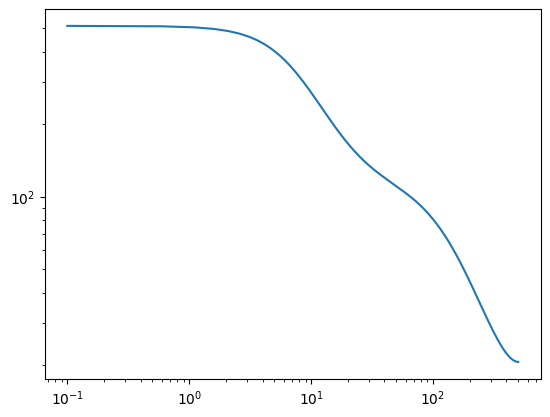

In [2]:
# Simulate spectral form
fs = 1000
freqs = np.linspace(.1, fs//2, fs)

k = np.arange(1, 2)
exp = np.exp(-2j * np.pi * np.outer(freqs, k) / fs).T

powers = ar_spectrum(exp, 0.95, 1.) + ar_spectrum(exp, 0.4, 40.)

plt.loglog(freqs, powers);

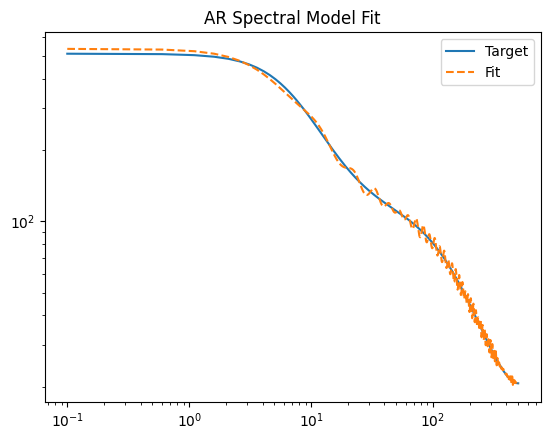

In [12]:
# Warning: this is super slow to fit
#   Fit PSD with AR(20)
order = 100
ar = ARPSD(order, fs, ar_bounds=(-0.99, 0.99))
ar.fit(freqs, powers)
ar.plot()

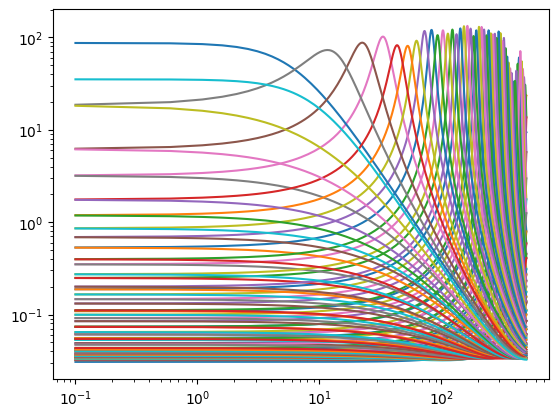

In [18]:
# Split AR parameters from scaling constant
phi, scale = -ar.params[:-1], ar.params[-1]

# Solve poly roots
coef = np.array([1, *phi])
p = np.polynomial.Polynomial(coef)
roots = p.roots()

# PSD: components and product
exp = np.exp(-1j * 2 * np.pi * freqs * (1/fs))
const = 1 / np.abs(p.coef[-1])**2

powers_prod = np.zeros((order, len(freqs)))
powers_fit = const

for i in range(order):
    powers_prod[i] = 1 / np.abs((exp-roots[i]))**2
    powers_fit *= powers_prod[i]

# Plot
plt.figure(0)
for _powers in powers_prod:
    plt.loglog(freqs, (const/order) * _powers)